### Import necessary libraries

In [2]:
%pip install --upgrade scikit-learn==1.6.1 imbalanced-learn category-encoders numpy==1.26.4 pandas scipy

Note: you may need to restart the kernel to use updated packages.


In [199]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt
from pyproj import Transformer
import pickle
import seaborn as sns
from collections import Counter
from skimage.morphology import binary_opening, disk
import os

### Loading Data

In [156]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Sentinel2.csv
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/SampleSubmission.csv
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Sentinel1.csv
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Test.csv
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Orenburg_training_samples.shx
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Fergana_training_samples.dbf
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Fergana_training_samples.shp
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Orenburg_training_samples.dbf
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Fergana_training_samples.shx
/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Orenburg_training_samples.shp


In [157]:
# Load Sentinel-1 and 2
s1 = pd.read_csv("/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Sentinel1.csv").drop(columns=['date'])
s2 = pd.read_csv("/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Sentinel2.csv").drop(columns=['date'])

In [158]:
s1.head()

,ID,VH,VV,orbit,polarization,rel_orbit,translated_lat,translated_lon
0,ID_AFQOFP,-21.479683,-16.633259,DESCENDING,"[VV, VH]",78.0,41.652292,72.144256
1,ID_AFQOFP,-24.769110,-15.943674,DESCENDING,"[VV, VH]",78.0,41.652289,72.144375
2,ID_AFQOFP,-25.370838,-15.185609,DESCENDING,"[VV, VH]",78.0,41.652286,72.144495
3,ID_AFQOFP,-24.134005,-16.351102,DESCENDING,"[VV, VH]",78.0,41.652283,72.144614
4,ID_AFQOFP,-20.654249,-16.792723,DESCENDING,"[VV, VH]",78.0,41.652280,72.144733


In [159]:
s2.head()

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,ID,cloud_pct,solar_azimuth,solar_zenith,translated_lat,translated_lon
0,2169,1820,1328,1610,1670,1985,2446,2628,2598,2638,ID_ZHZRHO,6.980395,139.093139,22.625533,40.935173,71.617062
1,2151,1770,1306,1586,1640,1961,2495,2691,2684,2732,ID_ZHZRHO,6.980395,139.093139,22.625533,40.935171,71.617180
2,2169,1820,1456,1674,1808,1985,2446,2628,2486,2638,ID_ZHZRHO,6.980395,139.093139,22.625533,40.935085,71.616940
3,2169,1820,1284,1604,1658,1985,2446,2628,2658,2638,ID_ZHZRHO,6.980395,139.093139,22.625533,40.935083,71.617059
4,2151,1770,1242,1522,1564,1961,2495,2691,2696,2732,ID_ZHZRHO,6.980395,139.093139,22.625533,40.935081,71.617177


### Data Preparation

In [160]:
print(s1.columns)
print('\n')
print(s2.columns)

Index(['ID', 'VH', 'VV', 'orbit', 'polarization', 'rel_orbit',
       'translated_lat', 'translated_lon'],
      dtype='object')


Index(['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'ID',
       'cloud_pct', 'solar_azimuth', 'solar_zenith', 'translated_lat',
       'translated_lon'],
      dtype='object')


In [161]:
# shape of sentinel 1 & 2
print('s1 shape:', s1.shape)
print('\n')
print('s2 shape:', s2.shape)

s1 shape: (1752570, 8)


s2 shape: (5610393, 16)


In [162]:
# Sentinel 1 & 2 information
s1.info()
print('-'*50)
s2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752570 entries, 0 to 1752569
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   ID              object 
 1   VH              float64
 2   VV              float64
 3   orbit           object 
 4   polarization    object 
 5   rel_orbit       float64
 6   translated_lat  float64
 7   translated_lon  float64
dtypes: float64(5), object(3)
memory usage: 107.0+ MB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5610393 entries, 0 to 5610392
Data columns (total 16 columns):
 #   Column          Dtype  
---  ------          -----  
 0   B11             int64  
 1   B12             int64  
 2   B2              int64  
 3   B3              int64  
 4   B4              int64  
 5   B5              int64  
 6   B6              int64  
 7   B7              int64  
 8   B8              int64  
 9   B8A             int64  
 10  ID              object 
 11

In [163]:
# Check null values
print('s1')
print(s1.isna().sum())
print('-'*50)
print('s2')
print(s2.isna().sum())

s1
ID                0
VH                0
VV                0
orbit             0
polarization      0
rel_orbit         0
translated_lat    0
translated_lon    0
dtype: int64
--------------------------------------------------
s2
B11               0
B12               0
B2                0
B3                0
B4                0
B5                0
B6                0
B7                0
B8                0
B8A               0
ID                0
cloud_pct         0
solar_azimuth     0
solar_zenith      0
translated_lat    0
translated_lon    0
dtype: int64


### Extract Labelled GeoData

In [164]:
def load_training_data():
    fergana = gpd.read_file("/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Fergana_training_samples.shp")
    orenburg = gpd.read_file("/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Train/Orenburg_training_samples.shp")

    # Extract centroids if not points
    for gdf in [fergana, orenburg]:
        if not all(gdf.geometry.geom_type == "Point"):
            gdf['geometry'] = gdf.geometry.centroid
        gdf['lon'] = gdf.geometry.x
        gdf['lat'] = gdf.geometry.y
    
    gdf = pd.concat([fergana, orenburg])
    return gdf[['Cropland', 'lon', 'lat']]

In [165]:
train_gdf = load_training_data()
print(train_gdf.head())
print('\n')
print("Train lon range:", train_gdf['lon'].min(), train_gdf['lon'].max())
print("Train lat range:", train_gdf['lat'].min(), train_gdf['lat'].max())
print('\n')
print(f'train_gdf shape: {train_gdf.shape}')

   Cropland        lon        lat
0         0  71.749080  41.396323
1         0  72.901429  41.072193
2         1  72.463988  40.619055
3         0  72.197317  41.627590
4         0  71.312037  41.369462


Train lon range: 54.006673861691354 72.9859295922386
Train lat range: 40.00926404600921 52.982225224058766


train_gdf shape: (1000, 3)


### Feature Engineering

In [166]:
def calculate_vegetation_indices(df):
    """Calculate comprehensive vegetation indices from Sentinel-2 band data"""
    # Convert all bands to numeric
    sentinel_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    for band in sentinel_bands:
        if band in df.columns:
            df[band] = pd.to_numeric(df[band], errors='coerce')
    
    # Small constant to prevent division by zero
    eps = 1e-8
    
    # Essential indices
    df['NDVI'] = (df['B8'] - df['B4']) / (df['B8'] + df['B4'] + eps) # Vegetation health
    df['NDWI'] = (df['B3'] - df['B8']) / (df['B3'] + df['B8'] + eps) # Water content
    df['EVI'] = 2.5 * (df['B8'] - df['B4']) / (df['B8'] + 6*df['B4'] - 7.5*df['B2'] + 1 + eps)
    df['NDMI'] = (df['B8'] - df['B11']) / (df['B8'] + df['B11'] + eps)  # Moisture index
    df['NDVIre'] = (df['B8A'] - df['B5']) / (df['B8A'] + df['B5'] + eps)  # Red-edge vegetation index
    df['NBR'] = (df['B8'] - df['B12']) / (df['B8'] + df['B12'] + eps)  # Burn ratio index
    df['MSAVI'] = (2*df['B8'] + 1 - np.sqrt((2*df['B8']+1)**2 - 8*(df['B8']-df['B4']))) / 2
    df['ARVI'] = (df['B8'] - (2*df['B4'] - df['B2'])) / (df['B8'] + (2*df['B4'] - df['B2']) + eps)
    
    return df

In [167]:
def aggregate_features(df, id_col='ID'):
    # Aggregate basic statistics
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    agg_df = df.groupby(id_col).agg(
        ['mean', 'std', 'min', 'max', 'median', lambda x: x.quantile(0.75) - x.quantile(0.25)]
    )
    # Flatten multi-level columns and reset index
    agg_df.columns = [f'{col[0]}_{col[1]}' for col in agg_df.columns]
    agg_df = agg_df.reset_index()  # Convert ID index to column

    # Temporal features with proper column handling
    def temporal_features(group):
        group = group.select_dtypes(include=np.number)
        stats = group.agg(['mean', 'std', 'min', 'max', 'median', 'skew'])
        return stats.unstack()

    temporal = df.groupby(id_col).apply(temporal_features)
    # Flatten multi-level columns and preserve ID
    temporal.columns = [f'temp_{col[0]}_{col[1]}' for col in temporal.columns]
    temporal = temporal.reset_index()  # Convert ID index to column

    # Merge DataFrames
    agg_df = pd.merge(agg_df, temporal, on=id_col, how='left')
    return agg_df.fillna(0)

In [168]:
# Process Sentinel-2 data
s2 = calculate_vegetation_indices(s2)
print("Sentinel-2 columns:", s2.columns.tolist())
s2_agg = aggregate_features(s2, id_col='ID')

Sentinel-2 columns: ['B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'ID', 'cloud_pct', 'solar_azimuth', 'solar_zenith', 'translated_lat', 'translated_lon', 'NDVI', 'NDWI', 'EVI', 'NDMI', 'NDVIre', 'NBR', 'MSAVI', 'ARVI']


/tmp/ipykernel_36/3523434343.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temporal = df.groupby(id_col).apply(temporal_features)


In [169]:
s2_agg.head()

,ID,B11_mean,B11_std,B11_min,B11_max,B11_median,B11_<lambda_0>,B12_mean,B12_std,B12_min,...,temp_MSAVI_min,temp_MSAVI_max,temp_MSAVI_median,temp_MSAVI_skew,temp_ARVI_mean,temp_ARVI_std,temp_ARVI_min,temp_ARVI_max,temp_ARVI_median,temp_ARVI_skew
0,ID_ABQOQT,4006.207245,948.806093,627,5572,4281.0,1022.0,3214.522401,699.895483,646,...,-0.123960,0.665303,0.329532,-1.011734,0.100504,0.101173,-0.114045,0.464270,0.076244,0.614162
1,ID_ADDROF,3616.306531,657.104319,1475,9184,3625.0,688.0,3288.943469,612.300262,1137,...,-0.236896,0.803637,0.241448,0.574877,0.072481,0.113542,-0.299609,0.589308,0.041126,1.222055
2,ID_AFIWZH,3011.973886,594.528719,1486,6671,3075.0,477.0,2534.593781,591.611468,923,...,0.012564,0.931530,0.393998,0.220191,0.210646,0.164697,-0.072824,0.841440,0.172324,0.946930
3,ID_AFQOFP,4174.708865,970.557707,778,8468,4294.0,1122.0,3533.380821,834.848863,783,...,-0.077414,0.767588,0.218841,0.992132,0.037457,0.132526,-0.112920,0.621737,-0.009738,1.860276
4,ID_AHRONV,3161.708739,960.517873,617,8602,3416.0,1004.0,2645.720038,721.858187,723,...,-0.213251,0.533406,0.272362,-0.596858,0.067060,0.097224,-0.127633,0.376258,0.034451,0.912543


In [170]:
s2_agg.columns

Index(['ID', 'B11_mean', 'B11_std', 'B11_min', 'B11_max', 'B11_median',
       'B11_<lambda_0>', 'B12_mean', 'B12_std', 'B12_min',
       ...
       'temp_MSAVI_min', 'temp_MSAVI_max', 'temp_MSAVI_median',
       'temp_MSAVI_skew', 'temp_ARVI_mean', 'temp_ARVI_std', 'temp_ARVI_min',
       'temp_ARVI_max', 'temp_ARVI_median', 'temp_ARVI_skew'],
      dtype='object', length=277)

In [171]:
# Process Sentinel-1 data
print("\nSentinel-1 columns:", s1.columns.tolist())


Sentinel-1 columns: ['ID', 'VH', 'VV', 'orbit', 'polarization', 'rel_orbit', 'translated_lat', 'translated_lon']


In [172]:
# Preprocessing
for col in ['VV', 'VH']:
    s1[col] = pd.to_numeric(s1[col], errors='coerce')
s1['orbit'] = s1['orbit'].map({'DESCENDING':0, 'ASCENDING':1})

# Feature engineering
s1['VH/VV_ratio'] = s1['VH'] / (s1['VV'] + 1e-9)
s1['NDPI'] = (s1['VH'] - s1['VV']) / (s1['VH'] + s1['VV'] + 1e-9)
s1['RVI'] = np.sqrt(s1['NDPI'] + 0.5)

# Temporal aggregation
features = s1.groupby('ID').agg({
    'VH': ['mean','std','max'],
    'VV': ['mean','std'],
    'VH/VV_ratio': ['mean','std','max'],
    'RVI': ['mean','max'],
    'orbit': lambda x: (x==0).mean()
}).fillna(0)

# Rename columns
features.columns = [
    'VH_mean', 'VH_std', 'VH_max',
    'VV_mean', 'VV_std',
    'Ratio_mean', 'Ratio_std', 'Ratio_max',
    'RVI_mean', 'RVI_max',
    'Frac_descending'
]

s1 = s1.drop(columns = ['orbit', 'polarization'])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [173]:
s1.head()

,ID,VH,VV,rel_orbit,translated_lat,translated_lon,VH/VV_ratio,NDPI,RVI
0,ID_AFQOFP,-21.479683,-16.633259,78.0,41.652292,72.144256,1.291369,0.127160,0.791934
1,ID_AFQOFP,-24.769110,-15.943674,78.0,41.652289,72.144375,1.553538,0.216773,0.846625
2,ID_AFQOFP,-25.370838,-15.185609,78.0,41.652286,72.144495,1.670716,0.251137,0.866682
3,ID_AFQOFP,-24.134005,-16.351102,78.0,41.652283,72.144614,1.475986,0.192241,0.832010
4,ID_AFQOFP,-20.654249,-16.792723,78.0,41.652280,72.144733,1.229952,0.103120,0.776608


In [174]:
s1.columns

Index(['ID', 'VH', 'VV', 'rel_orbit', 'translated_lat', 'translated_lon',
       'VH/VV_ratio', 'NDPI', 'RVI'],
      dtype='object')

In [175]:
s1_agg = aggregate_features(s1, id_col='ID')
print("\nSentinel-1 aggregated columns:", s1_agg.columns.tolist())


Sentinel-1 aggregated columns: ['ID', 'VH_mean', 'VH_std', 'VH_min', 'VH_max', 'VH_median', 'VH_<lambda_0>', 'VV_mean', 'VV_std', 'VV_min', 'VV_max', 'VV_median', 'VV_<lambda_0>', 'rel_orbit_mean', 'rel_orbit_std', 'rel_orbit_min', 'rel_orbit_max', 'rel_orbit_median', 'rel_orbit_<lambda_0>', 'translated_lat_mean', 'translated_lat_std', 'translated_lat_min', 'translated_lat_max', 'translated_lat_median', 'translated_lat_<lambda_0>', 'translated_lon_mean', 'translated_lon_std', 'translated_lon_min', 'translated_lon_max', 'translated_lon_median', 'translated_lon_<lambda_0>', 'VH/VV_ratio_mean', 'VH/VV_ratio_std', 'VH/VV_ratio_min', 'VH/VV_ratio_max', 'VH/VV_ratio_median', 'VH/VV_ratio_<lambda_0>', 'NDPI_mean', 'NDPI_std', 'NDPI_min', 'NDPI_max', 'NDPI_median', 'NDPI_<lambda_0>', 'RVI_mean', 'RVI_std', 'RVI_min', 'RVI_max', 'RVI_median', 'RVI_<lambda_0>', 'temp_VH_mean', 'temp_VH_std', 'temp_VH_min', 'temp_VH_max', 'temp_VH_median', 'temp_VH_skew', 'temp_VV_mean', 'temp_VV_std', 'temp_VV_

/tmp/ipykernel_36/3523434343.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temporal = df.groupby(id_col).apply(temporal_features)


#### Merge satellite data

In [176]:
# Merge satellite data
satellite_data = pd.merge(s2_agg, s1_agg, on='ID', how='inner')
print(f"\nMerged satellite data shape: {satellite_data.shape}")


Merged satellite data shape: (600, 373)


In [177]:
satellite_data.head()

,ID,B11_mean,B11_std,B11_min,B11_max,B11_median,B11_<lambda_0>,B12_mean,B12_std,B12_min,...,temp_NDPI_min,temp_NDPI_max,temp_NDPI_median,temp_NDPI_skew,temp_RVI_mean,temp_RVI_std,temp_RVI_min,temp_RVI_max,temp_RVI_median,temp_RVI_skew
0,ID_ABQOQT,4006.207245,948.806093,627,5572,4281.0,1022.0,3214.522401,699.895483,646,...,-0.059688,0.970340,0.335235,0.335789,0.914371,0.075249,0.663560,1.212576,0.913912,0.056369
1,ID_ADDROF,3616.306531,657.104319,1475,9184,3625.0,688.0,3288.943469,612.300262,1137,...,-0.091455,4.080452,0.345740,2.980622,0.931351,0.097122,0.639175,2.140199,0.919641,1.369176
2,ID_AFIWZH,3011.973886,594.528719,1486,6671,3075.0,477.0,2534.593781,591.611468,923,...,-0.061736,1.889148,0.356537,1.731790,0.954549,0.129164,0.662015,1.545687,0.925493,1.331811
3,ID_AFQOFP,4174.708865,970.557707,778,8468,4294.0,1122.0,3533.380821,834.848863,783,...,-0.098585,0.772366,0.236837,0.453458,0.860752,0.064939,0.633574,1.127992,0.858392,0.211590
4,ID_AHRONV,3161.708739,960.517873,617,8602,3416.0,1004.0,2645.720038,721.858187,723,...,-0.029361,0.566651,0.260242,0.281183,0.870445,0.059869,0.686032,1.032788,0.871918,0.096412


In [178]:
satellite_data.columns

Index(['ID', 'B11_mean', 'B11_std', 'B11_min', 'B11_max', 'B11_median',
       'B11_<lambda_0>', 'B12_mean', 'B12_std', 'B12_min',
       ...
       'temp_NDPI_min', 'temp_NDPI_max', 'temp_NDPI_median', 'temp_NDPI_skew',
       'temp_RVI_mean', 'temp_RVI_std', 'temp_RVI_min', 'temp_RVI_max',
       'temp_RVI_median', 'temp_RVI_skew'],
      dtype='object', length=373)

In [179]:
# Get mean coordinates
coords = s2.groupby('ID')[['translated_lon', 'translated_lat']].mean().reset_index()

In [180]:
coords.head()

,ID,translated_lon,translated_lat
0,ID_ABQOQT,72.849372,41.510684
1,ID_ADDROF,71.910871,41.380469
2,ID_AFIWZH,72.190803,40.769864
3,ID_AFQOFP,72.144468,41.652098
4,ID_AHRONV,54.717736,51.641874


In [181]:
# Check if satellite coordinates are in UTM range (large numbers)
if coords['translated_lon'].max() > 180 or coords['translated_lat'].max() > 90:
    print("Converting satellite coordinates to WGS84...")
    
    # Transform UTM to WGS84
    transformer = Transformer.from_crs("EPSG:32640", "EPSG:4326", always_xy=True)  # Orenburg
    # For Fergana use EPSG:32642
    
    # Apply transformation
    wgs84_coords = []
    for _, row in coords.iterrows():
        # Check which zone it belongs to based on position
        if row['translated_lon'] > 500000:  # UTM Easting
            # Orenburg zone (EPSG:32640)
            lon, lat = transformer.transform(row['translated_lon'], row['translated_lat'])
        else:
            # Fergana zone (EPSG:32642)
            lon, lat = transformer.transform(row['translated_lon'], row['translated_lat'])
        wgs84_coords.append([lon, lat])
    
    coords[['lon_wgs84', 'lat_wgs84']] = np.array(wgs84_coords)
    # Use converted coordinates for matching
    coords['translated_lon'] = coords['lon_wgs84']
    coords['translated_lat'] = coords['lat_wgs84']

In [182]:
print("Train coordinates sample:")
print(train_gdf[['lon', 'lat']].head())
print('\n')
print("Train lon range:", train_gdf['lon'].min(), train_gdf['lon'].max())
print("Train lat range:", train_gdf['lat'].min(), train_gdf['lat'].max())
print('\n')
print("Test coordinates sample:")
print(coords[['translated_lon', 'translated_lat']].head())
print('\n')
print("Test lon range:", coords['translated_lon'].min(), coords['translated_lon'].max())
print("Test lat range:", coords['translated_lat'].min(), coords['translated_lat'].max())

Train coordinates sample:
         lon        lat
0  71.749080  41.396323
1  72.901429  41.072193
2  72.463988  40.619055
3  72.197317  41.627590
4  71.312037  41.369462


Train lon range: 54.006673861691354 72.9859295922386
Train lat range: 40.00926404600921 52.982225224058766


Test coordinates sample:
   translated_lon  translated_lat
0       72.849372       41.510684
1       71.910871       41.380469
2       72.190803       40.769864
3       72.144468       41.652098
4       54.717736       51.641874


Test lon range: 54.26461772506346 73.2074963114073
Test lat range: 40.27936508234601 53.23875936888679


In [183]:
# Increase threshold
MAX_DIST = 0.1

# Re-run KDTree matching
tree = KDTree(train_gdf[['lon', 'lat']].values)
distances, indices = tree.query(coords[['translated_lon', 'translated_lat']].values, k=1)
valid_mask = distances.flatten() <= MAX_DIST

labels = pd.DataFrame({
    'ID': coords['ID'],
    'label': np.where(valid_mask, train_gdf.iloc[indices.flatten()]['Cropland'].values, -1),
    'distance': distances.flatten()
})

In [184]:
labels.head()

,ID,label,distance
0,ID_ABQOQT,0,0.025001
1,ID_ADDROF,0,0.064437
2,ID_AFIWZH,1,0.025758
3,ID_AFQOFP,0,0.058255
4,ID_AHRONV,0,0.029404


In [185]:
# Filter valid labels
valid_labels = labels[labels['label'] != -1].drop(columns='distance')
print(f"Matched {len(valid_labels)}/{len(coords)} points to training labels")

# Merge features with labels
full_data = pd.merge(satellite_data, valid_labels, on='ID')
print(f"Final dataset size: {full_data.shape}")

Matched 491/600 points to training labels
Final dataset size: (491, 374)


In [186]:
full_data.head()

,ID,B11_mean,B11_std,B11_min,B11_max,B11_median,B11_<lambda_0>,B12_mean,B12_std,B12_min,...,temp_NDPI_max,temp_NDPI_median,temp_NDPI_skew,temp_RVI_mean,temp_RVI_std,temp_RVI_min,temp_RVI_max,temp_RVI_median,temp_RVI_skew,label
0,ID_ABQOQT,4006.207245,948.806093,627,5572,4281.0,1022.0,3214.522401,699.895483,646,...,0.970340,0.335235,0.335789,0.914371,0.075249,0.663560,1.212576,0.913912,0.056369,0
1,ID_ADDROF,3616.306531,657.104319,1475,9184,3625.0,688.0,3288.943469,612.300262,1137,...,4.080452,0.345740,2.980622,0.931351,0.097122,0.639175,2.140199,0.919641,1.369176,0
2,ID_AFIWZH,3011.973886,594.528719,1486,6671,3075.0,477.0,2534.593781,591.611468,923,...,1.889148,0.356537,1.731790,0.954549,0.129164,0.662015,1.545687,0.925493,1.331811,1
3,ID_AFQOFP,4174.708865,970.557707,778,8468,4294.0,1122.0,3533.380821,834.848863,783,...,0.772366,0.236837,0.453458,0.860752,0.064939,0.633574,1.127992,0.858392,0.211590,0
4,ID_AHRONV,3161.708739,960.517873,617,8602,3416.0,1004.0,2645.720038,721.858187,723,...,0.566651,0.260242,0.281183,0.870445,0.059869,0.686032,1.032788,0.871918,0.096412,0


In [187]:
# Prepare test meta and filter Sentinel data
test_meta = pd.read_csv("/kaggle/input/geoai-challenge-for-cropland-mapping-dry-dataset/Test.csv")
test_meta.tail()

,ID,location,translated_lat,translated_lon
595,ID_YVMNXE,Orenburg,52.630758,54.947987
596,ID_PSDKPW,Orenburg,52.294734,54.966770
597,ID_NKZXTH,Orenburg,52.503914,55.516565
598,ID_ZZLDKS,Orenburg,53.115558,55.872890
599,ID_THSWSY,Orenburg,53.024921,55.233032


In [188]:
test_ids = test_meta["ID"].unique()
s1_test = s1[s1["ID"].isin(test_ids)]
s2_test = s2[s2["ID"].isin(test_ids)]

# Apply all feature engineering to test set
s2_test = calculate_vegetation_indices(s2_test)

# Aggregate features for test set
s2_test = calculate_vegetation_indices(s2_test)
s1_test_feats = aggregate_features(s1_test)
s2_test_feats = aggregate_features(s2_test)

# Merge features
test_df = pd.merge(s2_test_feats, s1_test_feats, on="ID", how="left").fillna(0)

/tmp/ipykernel_36/3523434343.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temporal = df.groupby(id_col).apply(temporal_features)
/tmp/ipykernel_36/3523434343.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  temporal = df.groupby(id_col).apply(temporal_features)


In [189]:
test_df.head()

,ID,B11_mean,B11_std,B11_min,B11_max,B11_median,B11_<lambda_0>,B12_mean,B12_std,B12_min,...,temp_NDPI_min,temp_NDPI_max,temp_NDPI_median,temp_NDPI_skew,temp_RVI_mean,temp_RVI_std,temp_RVI_min,temp_RVI_max,temp_RVI_median,temp_RVI_skew
0,ID_ABQOQT,4006.207245,948.806093,627,5572,4281.0,1022.0,3214.522401,699.895483,646,...,-0.059688,0.970340,0.335235,0.335789,0.914371,0.075249,0.663560,1.212576,0.913912,0.056369
1,ID_ADDROF,3616.306531,657.104319,1475,9184,3625.0,688.0,3288.943469,612.300262,1137,...,-0.091455,4.080452,0.345740,2.980622,0.931351,0.097122,0.639175,2.140199,0.919641,1.369176
2,ID_AFIWZH,3011.973886,594.528719,1486,6671,3075.0,477.0,2534.593781,591.611468,923,...,-0.061736,1.889148,0.356537,1.731790,0.954549,0.129164,0.662015,1.545687,0.925493,1.331811
3,ID_AFQOFP,4174.708865,970.557707,778,8468,4294.0,1122.0,3533.380821,834.848863,783,...,-0.098585,0.772366,0.236837,0.453458,0.860752,0.064939,0.633574,1.127992,0.858392,0.211590
4,ID_AHRONV,3161.708739,960.517873,617,8602,3416.0,1004.0,2645.720038,721.858187,723,...,-0.029361,0.566651,0.260242,0.281183,0.870445,0.059869,0.686032,1.032788,0.871918,0.096412


In [190]:
# Train-test split
X = full_data.drop(columns=["ID", "label"])
y = full_data["label"]
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [191]:
X.head()

,B11_mean,B11_std,B11_min,B11_max,B11_median,B11_<lambda_0>,B12_mean,B12_std,B12_min,B12_max,...,temp_NDPI_min,temp_NDPI_max,temp_NDPI_median,temp_NDPI_skew,temp_RVI_mean,temp_RVI_std,temp_RVI_min,temp_RVI_max,temp_RVI_median,temp_RVI_skew
0,4006.207245,948.806093,627,5572,4281.0,1022.0,3214.522401,699.895483,646,4938,...,-0.059688,0.970340,0.335235,0.335789,0.914371,0.075249,0.663560,1.212576,0.913912,0.056369
1,3616.306531,657.104319,1475,9184,3625.0,688.0,3288.943469,612.300262,1137,8095,...,-0.091455,4.080452,0.345740,2.980622,0.931351,0.097122,0.639175,2.140199,0.919641,1.369176
2,3011.973886,594.528719,1486,6671,3075.0,477.0,2534.593781,591.611468,923,6238,...,-0.061736,1.889148,0.356537,1.731790,0.954549,0.129164,0.662015,1.545687,0.925493,1.331811
3,4174.708865,970.557707,778,8468,4294.0,1122.0,3533.380821,834.848863,783,7570,...,-0.098585,0.772366,0.236837,0.453458,0.860752,0.064939,0.633574,1.127992,0.858392,0.211590
4,3161.708739,960.517873,617,8602,3416.0,1004.0,2645.720038,721.858187,723,7629,...,-0.029361,0.566651,0.260242,0.281183,0.870445,0.059869,0.686032,1.032788,0.871918,0.096412


In [192]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64

In [193]:
X_test = test_df.drop(columns=["ID"])

# Now, find common columns between train and test
common_cols = list(set(X_train.columns) & set(X_test.columns))
print("Using only columns present in both train and test:", common_cols)

# Subset all sets to these columns
X_train = X_train[common_cols]
X_val = X_val[common_cols]
X_test = X_test[common_cols]

# Drop all-zero columns from train/val/test 
zero_cols = [col for col in X_train.columns if (X_train[col].sum() == 0 and X_val[col].sum() == 0 and X_test[col].sum() == 0)]
print("Dropping all-zero columns from train/val/test:", zero_cols)

X_train = X_train.drop(columns=zero_cols)
X_val = X_val.drop(columns=zero_cols)
X_test = X_test.drop(columns=zero_cols)

# Final alignment (should not error now)
X_val = X_val[X_train.columns]
X_test = X_test[X_train.columns]

Using only columns present in both train and test: ['temp_solar_zenith_mean', 'translated_lon_median_y', 'B8A_median', 'ARVI_mean', 'temp_B2_std', 'temp_EVI_max', 'RVI_<lambda_0>', 'B11_max', 'temp_VV_median', 'temp_B8A_max', 'temp_NDWI_min', 'B12_mean', 'temp_NDVIre_mean', 'B11_min', 'temp_VH_std', 'temp_B12_skew', 'temp_B11_mean', 'NBR_mean', 'B2_<lambda_0>', 'NDVIre_std', 'temp_RVI_skew', 'B8_median', 'NDWI_min', 'translated_lon_std_y', 'EVI_mean', 'B4_std', 'NBR_median', 'B4_max', 'temp_VH_skew', 'temp_B8A_std', 'solar_zenith_mean', 'B8A_min', 'temp_translated_lat_std_y', 'temp_B12_median', 'temp_rel_orbit_std', 'temp_NDMI_skew', 'temp_NDWI_std', 'temp_VH/VV_ratio_mean', 'translated_lon_<lambda_0>_y', 'EVI_max', 'temp_B8_median', 'temp_NDVIre_skew', 'temp_rel_orbit_min', 'cloud_pct_<lambda_0>', 'B11_std', 'temp_EVI_min', 'temp_NBR_std', 'temp_RVI_median', 'translated_lat_std_x', 'temp_translated_lon_mean_y', 'temp_translated_lat_min_y', 'NDWI_<lambda_0>', 'NDVIre_min', 'translated_

In [194]:
# After train-test split
feature_columns = X_train.columns

### Random Forest Model

Random Forest Validation Accuracy: 0.8181818181818182
Random Forest F1 Score: 0.8181818181818182


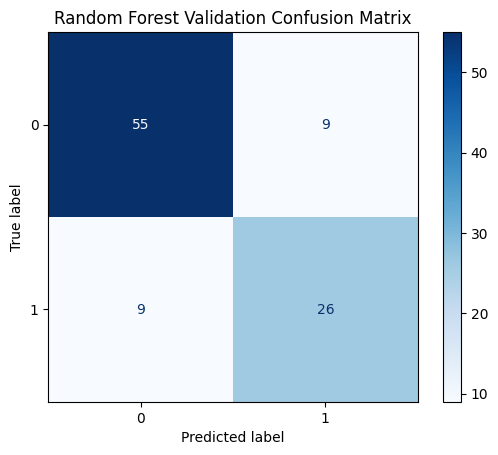

In [195]:
smote = SMOTE(random_state=42)
X_train_rf, y_train_rf = smote.fit_resample(X_train, y_train)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_rf, y_train_rf)

# Predict on validation set
y_val_pred_rf = rf.predict(X_val)

# Evaluate
print("Random Forest Validation Accuracy:", accuracy_score(y_val, y_val_pred_rf))
print("Random Forest F1 Score:", f1_score(y_val, y_val_pred_rf, average='weighted'))

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Random Forest Validation Confusion Matrix')
plt.show()

In [196]:
# Predict on test set
test_preds_rf = rf.predict(X_test)

# Save predictions to CSV
submission_rf = pd.DataFrame({'ID': test_df['ID'], 'label': test_preds_rf})
submission_rf.to_csv('submission_rf.csv', index=False)

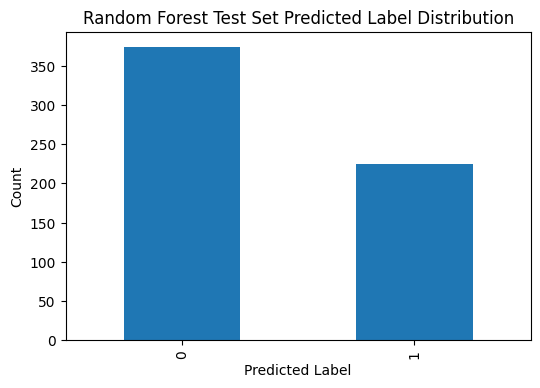

In [197]:
plt.figure(figsize=(6,4))
pd.Series(test_preds_rf).value_counts().sort_index().plot(kind='bar')
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.title('Random Forest Test Set Predicted Label Distribution')
plt.show()

In [200]:
# Save the model to a file
with open('random_forest_cropland.pkl', 'wb') as f:
    pickle.dump(rf, f)